In [ ]:
%pip install -r ../requirements.txt

In [1]:
# Only run once do not touch again
base_dir: bool = False

In [2]:
import os, sys

if not base_dir:
    os.chdir('../')
    base_dir = True

import tensorflow as tf
from tensorflow import keras

import numpy as np

import cv2

In [3]:
np.__version__, tf.__version__, keras.__version__

('2.0.2', '2.18.0', '3.7.0')

In [3]:
model = keras.models.load_model('models/SmallCNN.keras')

c:\Users\Theon\Downloads\view-prediction\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
from utils.data_tools import inbreast

image_batch_gen = inbreast.image_batch(compress=True, image_scale='Normalize', to_rgb=True)

image_batch = next(image_batch_gen)

No Dataframe provided, loading!


In [6]:
L_MLO = []
L_CC = []
R_MLO = []
R_CC = []

for data, image in zip(*image_batch):

    lat, view = data['Laterality'], data['View']

    if lat == 'L':

        if view == 'CC':

            L_CC.append(image)

        else:
    
            L_MLO.append(image)

    else:


        if view == 'CC':

            R_CC.append(image)

        else:
    
            R_MLO.append(image)


In [7]:
num_display_examples: int = 10

all_mammographs_ = [L_CC, L_MLO, R_CC, R_MLO]

assert all(map(lambda arr: arr.__len__() > num_display_examples, all_mammographs_)), f"Not all images have {num_display_examples} examples"

In [8]:
from utils.visualizer import visualizer

from matplotlib import pyplot as plt

from IPython.display import clear_output

display_image_size = (100,100)

def mammograph_labels_gen(): 
    yield from ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']

mammograph_labels_ = mammograph_labels_gen()

fig, axes = plt.subplots(4, num_display_examples, figsize=display_image_size)

def ax_gen():
    yield from axes.flat

ax_ = ax_gen()

for column, mammographs in zip(range(4), all_mammographs_):

    for i in range(num_display_examples):

        new_plot = visualizer.grad_cam(mammographs[i], model, color='orange')

        # Get model prediction

        prediction = 'MLO' if model.predict(
            np.expand_dims(mammographs[i], axis=0), verbose = 0
        ) >= 0.5 else 'CC'

        ax = next(ax_)

        if i == 0:

            curr_label = next(mammograph_labels_)

            ax.set_ylabel(curr_label, labelpad=10, fontsize=display_image_size[0] / 2, color='blue')

        # Resized to save memory
        ax.imshow(cv2.resize(new_plot._A.data, display_image_size))

        ax.set_xlabel(prediction, labelpad=10, fontsize=display_image_size[0] / 2, color='green' if curr_label.split('_')[1] ==  prediction else 'red')
        
        # ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        clear_output()

plt.show()

In [19]:
plot[0][0]._A.data

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

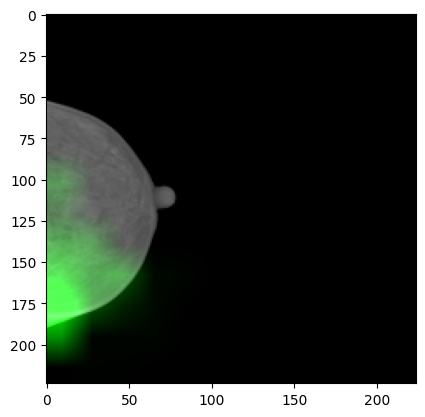

In [20]:
plt.imshow(plot[0][0]._A.data)